In [28]:
import networkx as nx
import pandas as pd
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [29]:
abyss_data = pd.read_csv('data/abyss_rank_activity.csv')
abyss_data.head()

,Version,Version Name,Total Samples,Effective Samples,Patch,Patch Label
0,1,Version: 3.0(Phase II),46302,37644,3.0,3.0 II
1,2,Version: 3.1(Phase I),43966,35745,3.1,3.1 I
2,3,Version: 3.1(Phase II),63368,51519,3.1,3.1 II
3,4,Version: 3.2(Phase I),60896,49509,3.2,3.2 I
4,5,Version: 3.2(Phase II),67901,59562,3.2,3.2 II


In [31]:
base_dir = 'graphs'

# Extract phase numbers and sort numerically
def extract_phase(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(1)) if match else float('inf')

# Get and sort files graph_1.pickle → graph_51.pickle
graph_files = sorted([f for f in os.listdir(base_dir) if f.startswith("graph_") and f.endswith(".pickle")],
                     key=extract_phase)

# Initialize centrality matrices as dictionaries (phase: {character: score})
degree_matrix = {}
betweenness_matrix = {}
eigenvector_matrix = {}

all_characters = set()

# Load each graph and compute centralities
for file in graph_files[1:]:
    phase = extract_phase(file)  # numeric phase number
    filepath = os.path.join(base_dir, file)
    
    with open(filepath, 'rb') as f:
        G = pickle.load(f)

    # Ensure graph is undirected
    if not isinstance(G, nx.Graph):
        G = nx.Graph(G)

    # Collect all characters in this graph
    nodes = list(G.nodes())
    all_characters.update(nodes)
    
    # Compute centralities
    # Using weights if available
    degree_cent = nx.degree_centrality(G)  # networkx uses normalized degree centrality

    # Betweenness
    for u, v, data in G.edges(data=True):
        if 'weight' in data and data['weight'] != 0:
            data['distance'] = 1.0 / data['weight']
        else:
            data['distance'] = float('inf')
    betweenness_cent = nx.betweenness_centrality(G, weight='distance', normalized=True)

    try:
        eigenvector_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=500)
    except nx.PowerIterationFailedConvergence:
        print(f"  Eigenvector centrality did not converge for Phase {phase}. Filling with NaN.")
        eigenvector_cent = {node: np.nan for node in nodes}

    # Store values in phase dictionaries
    degree_matrix[phase] = degree_cent
    betweenness_matrix[phase] = betweenness_cent
    eigenvector_matrix[phase] = eigenvector_cent

# Convert to DataFrames
all_characters = sorted(all_characters)  # consistent row ordering
phases = sorted(degree_matrix.keys())  # sorted phase ordering

def build_matrix(matrix_dict, name):
    df = pd.DataFrame(index=all_characters, columns=phases, dtype=float)
    for phase in phases:
        for char in all_characters:
            df.at[char, phase] = matrix_dict.get(phase, {}).get(char, np.nan)
    df.to_csv(f"data/{name}_centrality_matrix.csv")
    return df

degree_df = build_matrix(degree_matrix, "degree")
betweenness_df = build_matrix(betweenness_matrix, "betweenness")
eigenvector_df = build_matrix(eigenvector_matrix, "eigenvector")


In [32]:
def raw_cos(a, b):
    # Only consider indices where both a and b are non-null
    common_idx = a.notna() & b.notna()
    
    # Return 0 if no common ratings
    if common_idx.sum() == 0:
        return 0
    
    # Extract the common ratings
    v1 = a[common_idx].values
    v2 = b[common_idx].values
    
    # Compute cosine similarity
    numerator = np.dot(v1, v2)
    denom = np.linalg.norm(v1) * np.linalg.norm(v2)
    
    if denom == 0:
        return 0
    
    return numerator / denom

In [33]:
eig_meta_changes = []
for version in eigenvector_df.columns[:-1]:
    prev_version = eigenvector_df[version]
    curr_version = eigenvector_df[version + 1]
    eig_meta_changes.append(raw_cos(prev_version, curr_version))

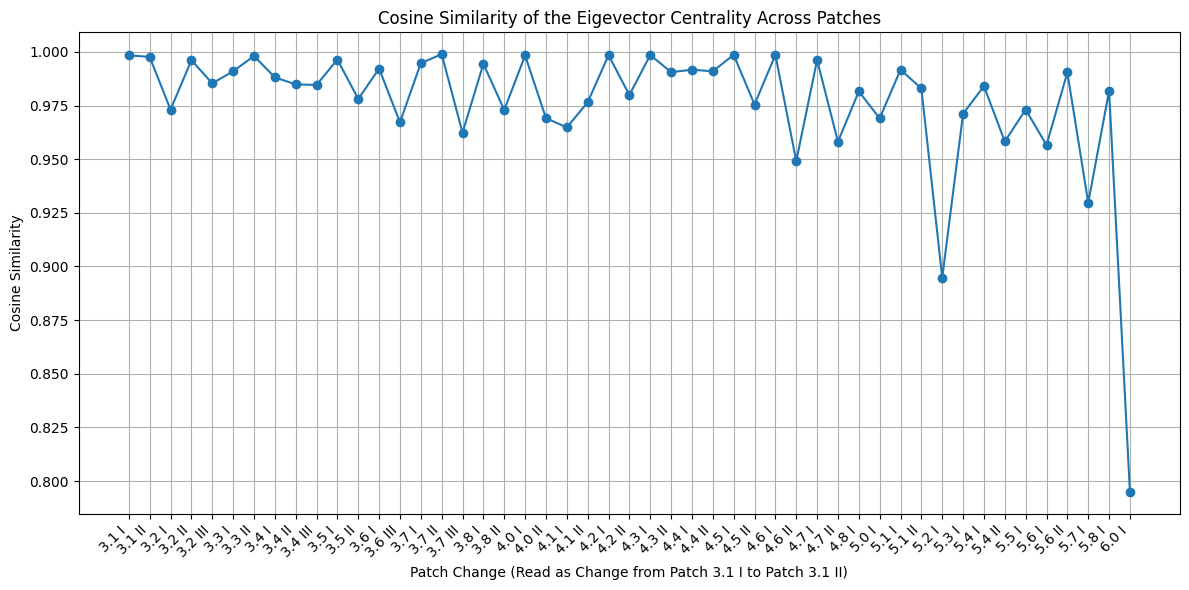

In [18]:
# Then because we are taking the change, we need a differenced
differenced_df = abyss_data.iloc[1:50]

plt.figure(figsize=(12, 6))
plt.plot(differenced_df['Version'], eig_meta_changes, marker='o')

plt.title('Cosine Similarity of the Eigevector Centrality Across Patches')
plt.xlabel('Patch Change (Read as Change from Patch 3.1 I to Patch 3.1 II)')
plt.ylabel('Cosine Similarity')
plt.grid(True)

# Apply Patch_Labeled as tick labels
plt.xticks(ticks=differenced_df['Version'], labels=differenced_df['Patch Label'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [19]:
betwenness_meta_changes = []
for version in betweenness_df.columns[:-1]:
    prev_version = betweenness_df[version]
    curr_version = betweenness_df[version + 1]
    betwenness_meta_changes.append(raw_cos(prev_version, curr_version))

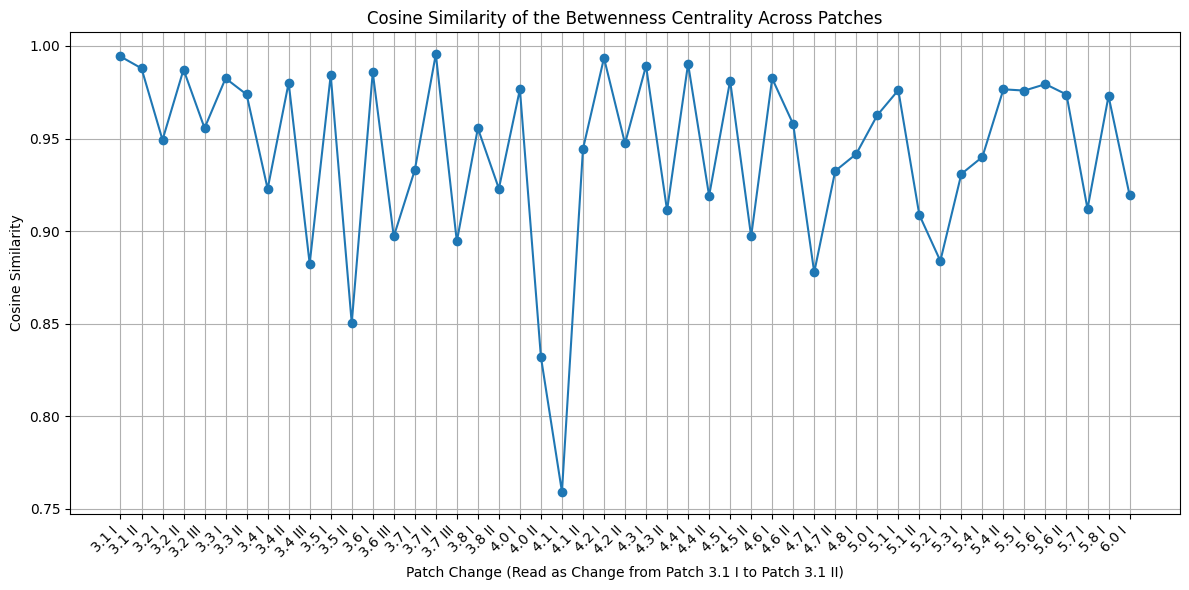

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(differenced_df['Version'], betwenness_meta_changes, marker='o')

plt.title('Cosine Similarity of the Betwenness Centrality Across Patches')
plt.xlabel('Patch Change (Read as Change from Patch 3.1 I to Patch 3.1 II)')
plt.ylabel('Cosine Similarity')
plt.grid(True)

# Apply Patch_Labeled as tick labels
plt.xticks(ticks=differenced_df['Version'], labels=differenced_df['Patch Label'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [21]:
pd.read_csv('abyss_rank_activity.csv')

,Version,Version Name,Total Samples,Effective Samples,Patch,Patch Label
0,1,Version: 3.0(Phase II),46302,37644,3.0,3.0 II
1,2,Version: 3.1(Phase I),43966,35745,3.1,3.1 I
2,3,Version: 3.1(Phase II),63368,51519,3.1,3.1 II
3,4,Version: 3.2(Phase I),60896,49509,3.2,3.2 I
4,5,Version: 3.2(Phase II),67901,59562,3.2,3.2 II
5,6,Version: 3.2(Phase III),56830,49851,3.2,3.2 III
6,7,Version: 3.3(Phase I),83972,72892,3.3,3.3 I
7,8,Version: 3.3(Phase II),82987,72037,3.3,3.3 II
8,9,Version: 3.4(Phase I),79539,69044,3.4,3.4 I
9,10,Version: 3.4(Phase II),111641,92265,3.4,3.4 II


In [22]:
degree_meta_changes = []
for version in degree_df.columns[:-1]:
    prev_version = degree_df[version]
    curr_version = degree_df[version + 1]
    degree_meta_changes.append(raw_cos(prev_version, curr_version))

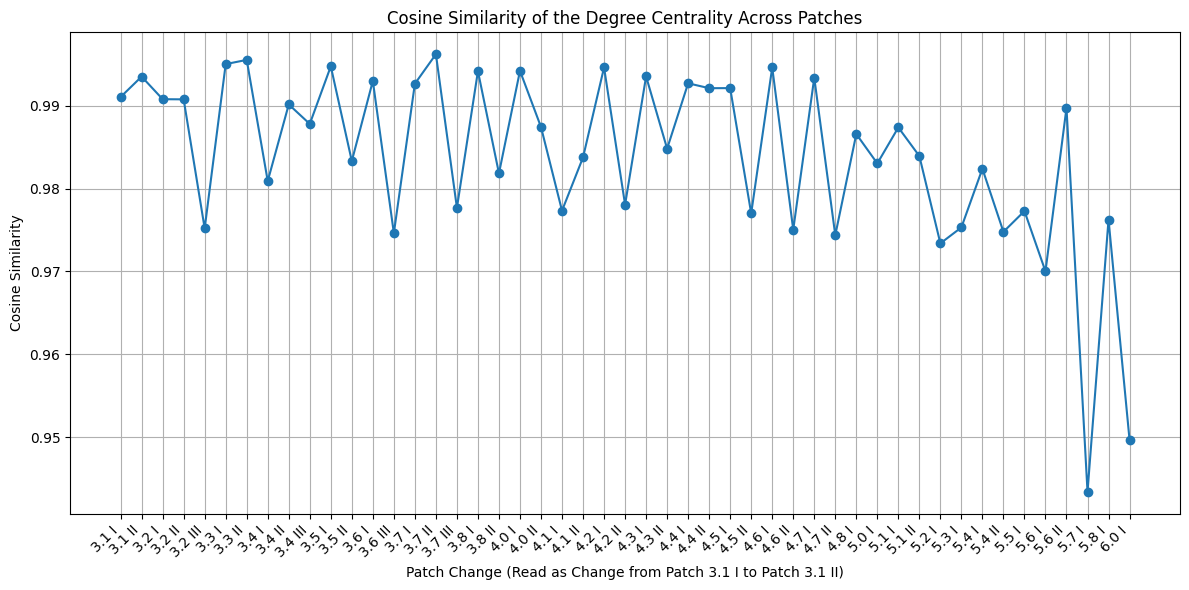

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(differenced_df['Version'], degree_meta_changes, marker='o')

plt.title('Cosine Similarity of the Degree Centrality Across Patches')
plt.xlabel('Patch Change (Read as Change from Patch 3.1 I to Patch 3.1 II)')
plt.ylabel('Cosine Similarity')
plt.grid(True)

# Apply Patch_Labeled as tick labels
plt.xticks(ticks=differenced_df['Version'], labels=differenced_df['Patch Label'], rotation=45, ha='right')

plt.tight_layout()
plt.show()
